<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Format-Data-&amp;-add-additional-columns" data-toc-modified-id="Format-Data-&amp;-add-additional-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Format Data &amp; add additional columns</a></span></li><li><span><a href="#EDA---Exploratory-Data-Analysis" data-toc-modified-id="EDA---Exploratory-Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA - Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Basic-data-properties" data-toc-modified-id="Basic-data-properties-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Basic data properties</a></span></li><li><span><a href="#Number-of-goods-vs-bads-(nans-vs-non-nans)" data-toc-modified-id="Number-of-goods-vs-bads-(nans-vs-non-nans)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Number of goods vs bads (nans vs non-nans)</a></span></li></ul></li><li><span><a href="#Plot-Histograms" data-toc-modified-id="Plot-Histograms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot Histograms</a></span></li><li><span><a href="#Pandas-Testing" data-toc-modified-id="Pandas-Testing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Pandas Testing</a></span></li></ul></div>

# Imports

In [49]:
# Imports
import csv
import os
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

# Load data

In [50]:
filename = os.path.join('data','employee_retention_data.csv')
# Load data to pandas
df = pd.read_csv(filename)
df.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


# Format Data & add additional columns

In [51]:
# Convert to date times
df['join_date'] = pd.to_datetime(df['join_date'])
df['quit_date'] = pd.to_datetime(df['quit_date'])

In [52]:
# Add column for still working
df['still_working'] = pd.isnull(df['quit_date'])

In [53]:
# Add a column for quit date_minus join_date
df['duration'] = df['quit_date'] - df['join_date']

# Convert to days (this is a float)
df['duration'] = df['duration'].dt.days

In [54]:
# Duration for those still working is null. Convert this to duration worked up until today. 
# (Alternative way to do this is to replace nan quit_dates to today)
today = pd.to_datetime('2015-12-13')
duration_stillemployed = today - df.loc[df.still_working == True,'join_date']
df.loc[df.still_working == True,'duration'] = duration_stillemployed.dt.days

In [55]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,True,426.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040.0


In [56]:
# Add "min" columns
# These columns assume the employee quits on the last day of the data set - 2015/12/13
# These will be used for later analysis

# Add quit_date_min
df['quit_date_min'] = df['quit_date']
df.loc[pd.isnull(df['quit_date']),['quit_date_min']] = pd.to_datetime('2015/12/13')

In [57]:
# Add duration_min
df['duration_min'] = df['quit_date_min'] - df['join_date']

# Convert to days
df['duration_min'] = df['duration_min'].dt.days

In [58]:
# Get rid of this, since we no longer need
df = df.drop('quit_date_min',1)

In [59]:
# Add single column for only year
join_year = df['join_date'].map(lambda ts: ts.year);
df['join_year'] = join_year

In [60]:
# Add columns for join year
#df['joined2011']
df['j2011'] = df['join_date'] < pd.to_datetime('2012')
df['j2012'] = (df['join_date'] >= pd.to_datetime('2012')) & (df['join_date'] < pd.to_datetime('2013'))
df['j2013'] = (df['join_date'] >= pd.to_datetime('2013')) & (df['join_date'] < pd.to_datetime('2014'))
df['j2014'] = (df['join_date'] >= pd.to_datetime('2014')) & (df['join_date'] < pd.to_datetime('2015'))
df['j2015'] = (df['join_date'] >= pd.to_datetime('2015')) & (df['join_date'] < pd.to_datetime('2016'))

In [61]:
# Create churn status, which is the smae as still_working, but converted to float
df['still_working_numeric'] = df['quit_date'].notna().round()          # Borrowed from Dave R
df['still_working_numeric'] = df['still_working'].astype(float)

In [62]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585.0,585,2014,False,False,False,True,False,0.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340.0,340,2013,False,False,True,False,False,0.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,True,426.0,426,2014,False,False,False,True,False,1.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389.0,389,2012,False,True,False,False,False,0.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040.0,1040,2011,True,False,False,False,False,0.0


In [63]:
df.describe()

,employee_id,company_id,seniority,salary,duration,duration_min,join_year,still_working_numeric
count,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478,574.319083,574.319083,2012.995709,0.453081
std,288909.026101,2.700011,8.089520,76058.184573,361.592379,361.592379,1.395940,0.497804
min,36.000000,1.000000,1.000000,17000.000000,3.000000,3.000000,2011.000000,0.000000
25%,250133.750000,1.000000,7.000000,79000.000000,333.000000,333.000000,2012.000000,0.000000
50%,500793.000000,2.000000,14.000000,123000.000000,424.000000,424.000000,2013.000000,0.000000
75%,753137.250000,5.000000,21.000000,187000.000000,781.000000,781.000000,2014.000000,1.000000
max,999969.000000,12.000000,99.000000,408000.000000,1777.000000,1777.000000,2015.000000,1.000000


# EDA - Exploratory Data Analysis

## Basic data properties

In [64]:
# Data types
print(df.dtypes)

employee_id                     float64
company_id                        int64
dept                             object
seniority                         int64
salary                          float64
join_date                datetime64[ns]
quit_date                datetime64[ns]
still_working                      bool
duration                        float64
duration_min                      int64
join_year                         int64
j2011                              bool
j2012                              bool
j2013                              bool
j2014                              bool
j2015                              bool
still_working_numeric           float64
dtype: object


In [65]:
# Number of unique companies
print('Unique company ids')
print(df.company_id.unique())
print('Number of unqiue companies = {}'.format(str(len(df.company_id.unique()))))

Unique company ids
[ 7  4  2  9  1  6 10  5  3  8 11 12]
Number of unqiue companies = 12


In [66]:
# Number of unique depts
print('Unique company ids')
print(df.dept.unique())
print('Number of unqiue depts = {}'.format(str(len(df.dept.unique()))))

Unique company ids
['customer_service' 'marketing' 'data_science' 'engineer' 'sales' 'design']
Number of unqiue depts = 6


In [67]:
# Number of unique seniority
print('Unique company ids')
print(df.seniority.unique())
print('Number of unqiue seniorities = {}'.format(str(len(df.seniority.unique()))))

Unique company ids
[28 20 14 23 21  4  7 13 17  1 10  6 19 15 26 27  5 18 16 25  9  2 29  3
  8 22 24 12 11 98 99]
Number of unqiue seniorities = 31


In [68]:
# Sort senorities
foo = df.seniority.unique()
foo.sort()

In [69]:
print("Number of years experience when hired, sorted unique values: " + str(foo))

Number of years experience when hired, sorted unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 98 99]


In [70]:
# For some reason, some people hae 98 or 99 years experience? Look at these values...

# experience = 98 - one lucky engineer
df[df['seniority'] == 98]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,False,1123.0,1123,2011,True,False,False,False,False,0.0


In [71]:
# experience = 99
df[df['seniority'] == 99]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06,False,864.0,864,2011,True,False,False,False,False,0.0


In [72]:
# Replace these values with more reasonable numbers

df = df.replace({'seniority': 98}, 40)
df = df.replace({'seniority': 99}, 40)
# Verify it works
df[24700:24704]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
24700,97289.0,10,engineer,40,266000.0,2011-12-13,2015-01-09,False,1123.0,1123,2011,True,False,False,False,False,0.0
24701,604052.0,1,marketing,40,185000.0,2011-07-26,2013-12-06,False,864.0,864,2011,True,False,False,False,False,0.0


## Number of goods vs bads (nans vs non-nans)

In [73]:
# Save dataframs containing only nans and only non-nans
df_good = df.dropna()
df_bad = df[pd.isnull(df['quit_date'])]

In [74]:
df_good.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585.0,585,2014,False,False,False,True,False,0.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340.0,340,2013,False,False,True,False,False,0.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389.0,389,2012,False,True,False,False,False,0.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040.0,1040,2011,True,False,False,False,False,0.0
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,False,578.0,578,2012,False,True,False,False,False,0.0


In [75]:
df_bad.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,True,426.0,426,2014,False,False,False,True,False,1.0
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,True,783.0,783,2013,False,False,True,False,False,1.0
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT,True,648.0,648,2014,False,False,False,True,False,1.0
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,True,1279.0,1279,2012,False,True,False,False,False,1.0
11,904158.0,2,marketing,17,230000.0,2015-05-11,NaT,True,216.0,216,2015,False,False,False,False,True,1.0


In [76]:
# Lengths
N = len(df)

Ngood = len(df_good)
Nbad2 = N-Ngood
Nbad = len(df_bad)

In [77]:
print('N={}, Ngood={}, Nbad={}, Nbad2={}'.format(str(N),str(Ngood),str(Nbad),str(Nbad2)))

N=24702, Ngood=13510, Nbad=11192, Nbad2=11192


# Plot Histograms

In [78]:
# Copy before messing
df2 = df.copy();

In [79]:
df2.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585.0,585,2014,False,False,False,True,False,0.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340.0,340,2013,False,False,True,False,False,0.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,True,426.0,426,2014,False,False,False,True,False,1.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389.0,389,2012,False,True,False,False,False,0.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040.0,1040,2011,True,False,False,False,False,0.0


<Figure size 432x288 with 0 Axes>

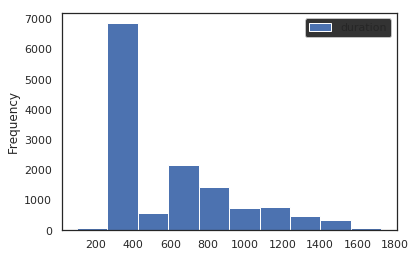

In [80]:
# Plot durations of all still working
foo = df.loc[df['still_working'] == False,['duration']]
plt.figure();
foo.plot.hist();

<Figure size 432x288 with 0 Axes>

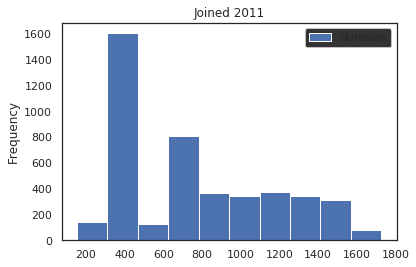

<Figure size 432x288 with 0 Axes>

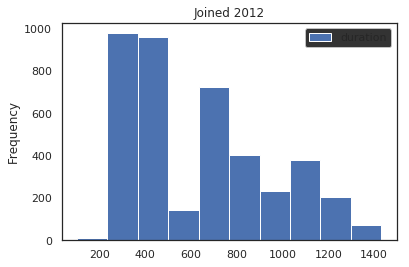

<Figure size 432x288 with 0 Axes>

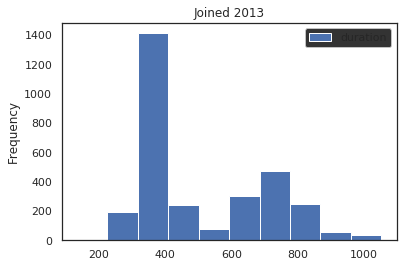

<Figure size 432x288 with 0 Axes>

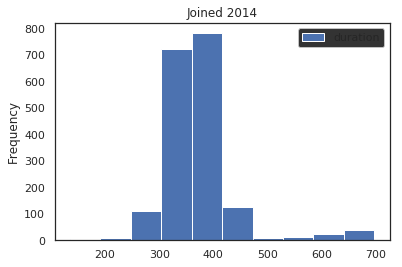

<Figure size 432x288 with 0 Axes>

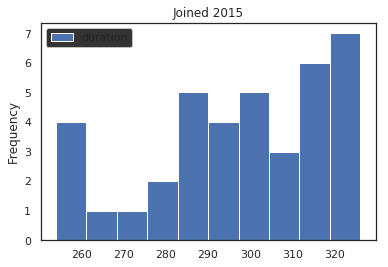

In [81]:
# Joined in 2011
foo = df.loc[(df['still_working'] == False) & (df['j2011']),['duration']]
plt.figure();
foo.plot.hist();
plt.title('Joined 2011');

# Joined in 2012
foo = df.loc[(df['still_working'] == False) & (df['j2012']),['duration']]
plt.figure();
foo.plot.hist();
plt.title('Joined 2012');

# Joined in 2013
foo = df.loc[(df['still_working'] == False) & (df['j2013']),['duration']]
plt.figure();
foo.plot.hist();
plt.title('Joined 2013');

# Joined in 2014
foo = df.loc[(df['still_working'] == False) & (df['j2014']),['duration']]
plt.figure();
foo.plot.hist();
plt.title('Joined 2014');

# Joined in 2015
foo = df.loc[(df['still_working'] == False) & (df['j2015']),['duration']]
plt.figure();
foo.plot.hist();
plt.title('Joined 2015');

In [82]:
# Appears that one group tends to quit after around 300-400 days; some stragglers (long tail)
# The data for employees that join in 2015 is highly biased.

# Pandas Testing

In [83]:
# Two different types of methods for pulling out columns
a = df['company_id']
b = df.company_id

In [84]:
# How to smartly index rows
inds = (df['still_working'] == False) & (df['j2011'] == True)

# Note: the round brakets are necessary:
# inds = df['still_working'] == False & df['j2011'].bool() == True
# produces an error for some reason


# inds = df[('still_working'] == False & (df['still_working'] == False)
# inds = df['still_working'] == False 

In [85]:
foo = df.loc[inds,['duration','salary']]
foo.head()

,duration,salary
4,1040.0,276000.0
16,723.0,88000.0
22,1316.0,144000.0
25,619.0,110000.0
27,347.0,223000.0


In [86]:
# Another way

In [87]:
foo = df.query('company_id == 1 and not still_working')
foo.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
12,939058.0,1,marketing,1,48000.0,2012-12-10,2013-11-15,False,340.0,340,2012,False,True,False,False,False,0.0
15,265226.0,1,data_science,4,80000.0,2014-05-27,2015-07-10,False,409.0,409,2014,False,False,False,True,False,0.0
28,888375.0,1,customer_service,5,75000.0,2011-08-01,2013-10-04,False,795.0,795,2011,True,False,False,False,False,0.0
31,476097.0,1,customer_service,23,111000.0,2012-07-16,2015-05-15,False,1033.0,1033,2012,False,True,False,False,False,0.0
45,537932.0,1,customer_service,7,89000.0,2014-08-18,2015-08-13,False,360.0,360,2014,False,False,False,True,False,0.0


# Seaborn testing

## Pairplot

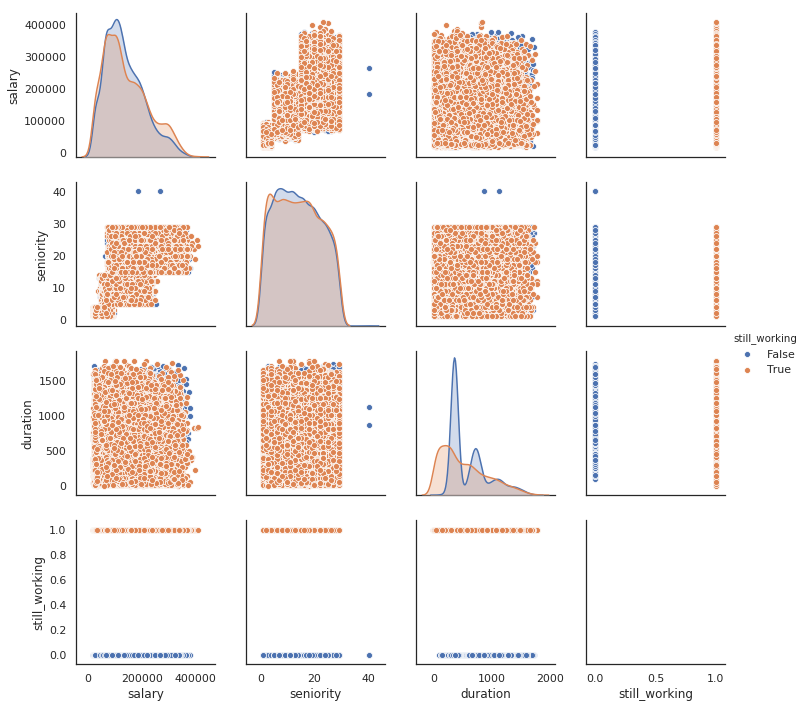

In [88]:
# sns.pairplot(df[['salary','seniority','duration','still_working_numeric']], hue='still_working_numeric');   # hue is float
sns.pairplot(df[['salary','seniority','duration','still_working']], hue='still_working');       # hue is boolean

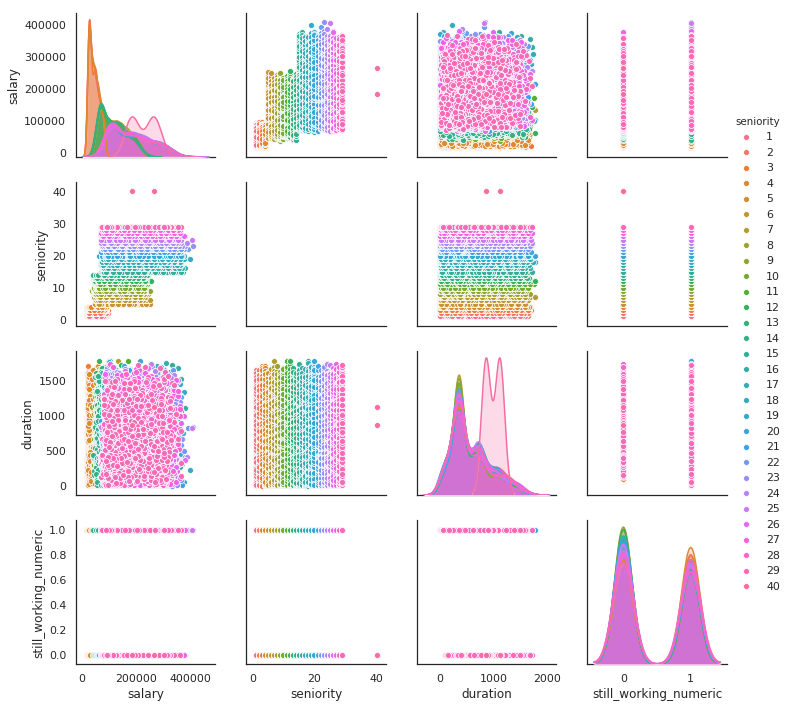

In [89]:
sns.pairplot(df[['salary','seniority','duration','still_working_numeric']], hue='seniority');

## Histograms

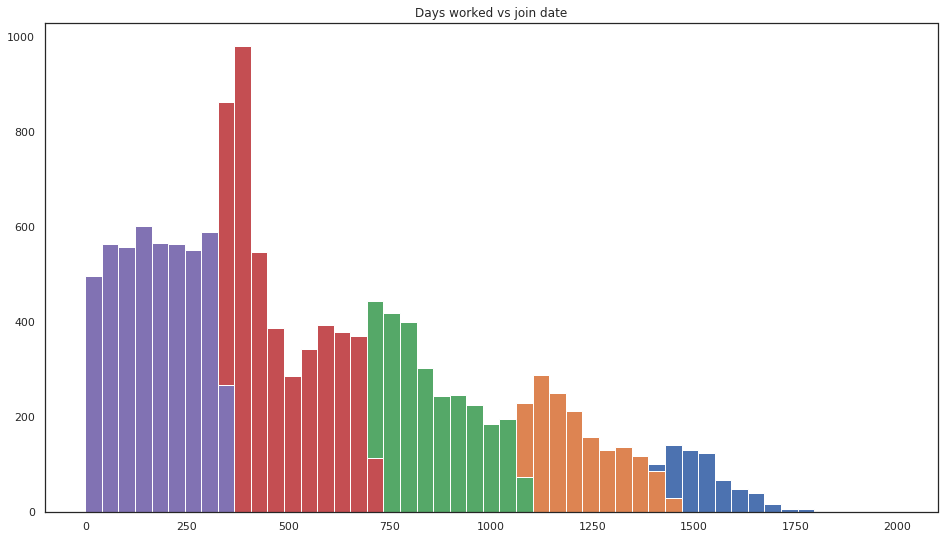

In [90]:
# Plot histogram with multiple overlays
plt.figure(figsize = (16, 9))
plt.hist(
    df.query('j2011')['duration'],
    bins = np.linspace(0,2000,50)
)
plt.hist(
    df.query('j2012')['duration'],
    bins = np.linspace(0,2000,50)
)
plt.hist(
    df.query('j2013')['duration'],
    bins = np.linspace(0,2000,50)
)
plt.hist(
    df.query('j2014')['duration'],
    bins = np.linspace(0,2000,50)
)
plt.hist(
    df.query('j2015')['duration'],
    bins = np.linspace(0,2000,50)
)
plt.title('Days worked vs join date');

In [91]:
df.keys()

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'still_working', 'duration', 'duration_min', 'join_year',
       'j2011', 'j2012', 'j2013', 'j2014', 'j2015', 'still_working_numeric'],
      dtype='object')

## Violin plot

### Example

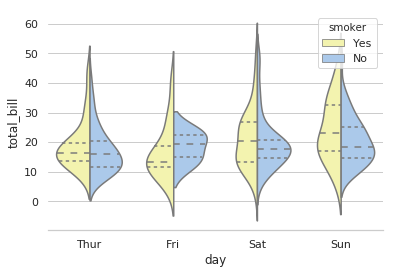

In [92]:
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="day", y="total_bill", hue="smoker",
               split=True, inner="quart",
               palette={"Yes": "y", "No": "b"},
               data=tips)
sns.despine(left=True)

In [93]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### My data

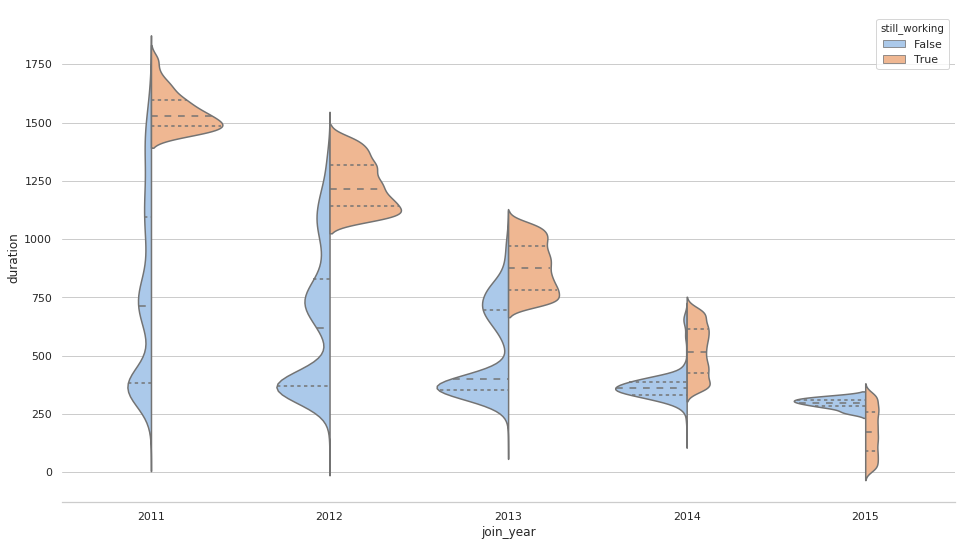

In [94]:
# Draw a nested violinplot and split the violins for easier comparison

plt.figure(figsize = (16, 9))
sns.violinplot(x="join_year", y="duration", hue="still_working",
               split=True, inner="quart",
#                palette={"Yes": "y", "No": "b"},
               data=df)
sns.despine(left=True)

## FacetPlot 

### Their data

In [105]:
mydf = df.copy()

/home/davestanley/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/home/davestanley/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/home/davestanley/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/home/davestanley/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decor

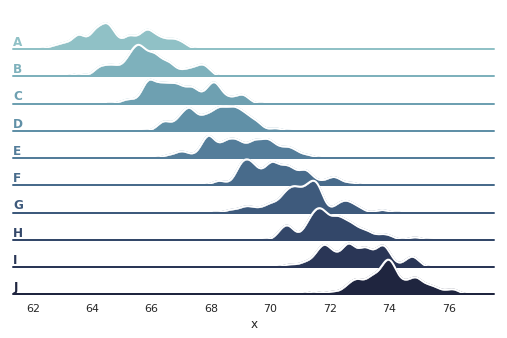

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [114]:
df.head()

,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E


In [115]:
# Restore my df
df = mydf.copy()

### My data

In [116]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,still_working,duration,duration_min,join_year,j2011,j2012,j2013,j2014,j2015,still_working_numeric
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585.0,585,2014,False,False,False,True,False,0.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340.0,340,2013,False,False,True,False,False,0.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,True,426.0,426,2014,False,False,False,True,False,1.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389.0,389,2012,False,True,False,False,False,0.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040.0,1040,2011,True,False,False,False,False,0.0


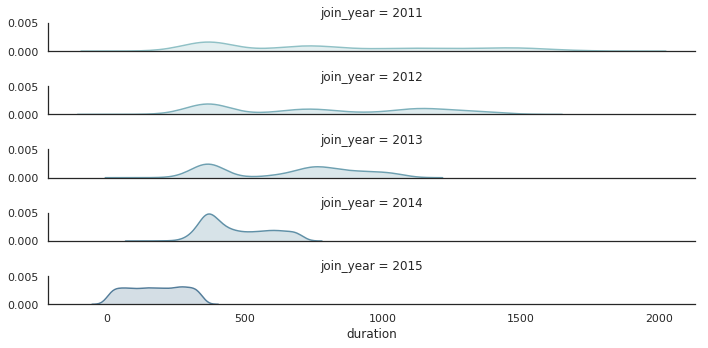

In [138]:
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, col='duration',row="join_year", hue="salary", aspect=15, height=.5, palette=pal)
# g = sns.FacetGrid(df,row="join_year", aspect=15, height=.5, palette=pal);
g = sns.FacetGrid(df,row="join_year", hue = "join_year", aspect=10, height=1, palette=pal);
# g = sns.FacetGrid(df,row="join_year", aspect=10, height=1, palette=pal);
g.map(sns.kdeplot, "duration", shade=True)
# g.map(sns.kdeplot, "duration", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
# g.map(sns.kdeplot, "duration", clip_on=False, color="w", lw=2, bw=.2)

In [132]:
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)


## FacetPlot 

### Their data

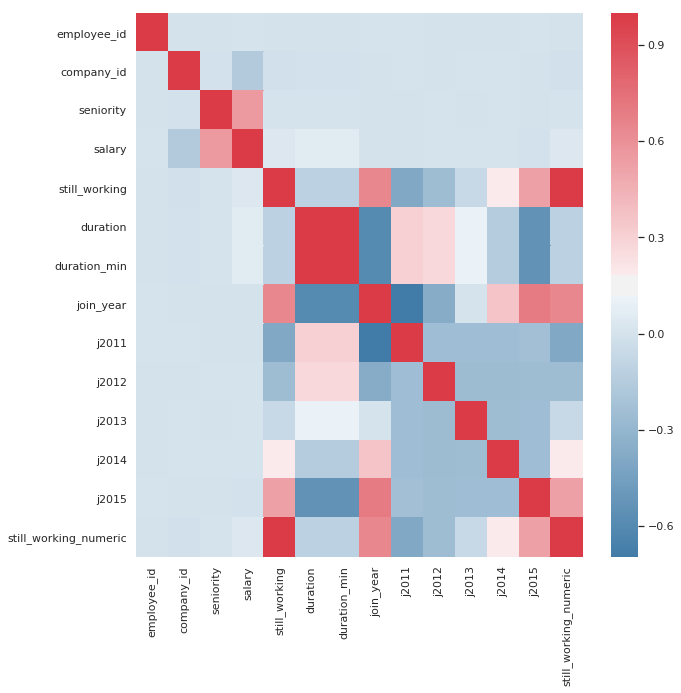

In [143]:
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), cmap = sns.diverging_palette(240, 10, n = 256))

# Modeling



In [144]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix





In [146]:
target = 'still_working_numeric'
features = ['salary', 'seniority', 'dept',
           'dept_customer_service', 'dept_data_science', 'dept_design', 
            'dept_engineer', 'dept_marketing', 'dept_sales', 
            'salary', 'seniority', 'internal_salary_zscore',
           'profession_salary_zscore', 'dept_experience_fraction', 'previous_days_worked',
           'career_fraction_in_company', 'profession_seniority_zscore',
           'dept_experience_disparity', 'step_up_1', 'step_up_2']

In [145]:
df.keys()

Index(['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date', 'still_working', 'duration', 'duration_min', 'join_year',
       'j2011', 'j2012', 'j2013', 'j2014', 'j2015', 'still_working_numeric'],
      dtype='object')